## <strong> Import Header </strong>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

## <strong> Set Device </strong>

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

## <strong> Set Hyper Parameters </strong>

In [30]:
image_size = 784 
noise = 100
batch_size = 128
total_epoch = 200
learning_rate = 0.0002
sample_dir= 'G_image'

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## <strong> Define Dataset / DataLoader </strong>

In [31]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize([0.5], [0.5])
])

train_data = dsets.MNIST(root='mnist' ,train=True, transform=transform, download=True)
test_data = dsets.MNIST(root='mnist' ,train=False, transform=transform, download=True)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

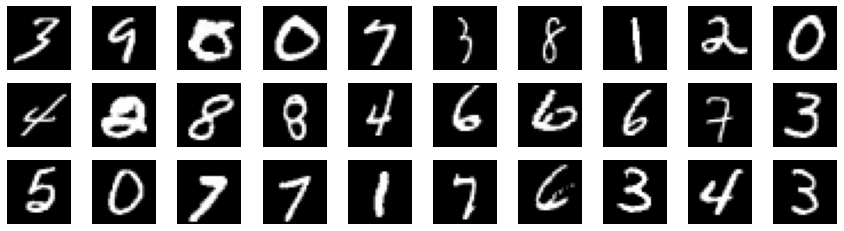

In [32]:
for images, _ in train_loader:
    fig, axs = plt.subplots(3, 10, figsize=(15, 4))
    for i in range(3):
        for j in range(10):
            if i*10+j < 30:
                image = images[i*13+j].numpy()
                axs[i][j].imshow(image.reshape(28,28), cmap='gray')
            
            axs[i][j].axis('off')
    break

## <strong> Define Model </strong>

<h3> <strong> Generative Model </strong> </h3>

In [33]:
class Gan(nn.Module):
  def __init__(self, noise, image_size):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(noise, 256),
        #nn.BatchNorm1d(256),
        nn.ReLU()
    )
    self.layer2 = nn.Sequential(
        nn.Linear(256, 512),
        #nn.BatchNorm1d(512),
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
        nn.Linear(512, image_size),
        nn.Tanh()
    )
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    return out

<h3> <strong> Discriminator Model </strong> </h3>

In [34]:
class Binary_Classifier(nn.Module):
  def __init__(self, image_size):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Linear(image_size, 512),
        #nn.BatchNorm1d(512),
        nn.LeakyReLU(0.2)
    )
    self.layer2 = nn.Sequential(
        nn.Linear(512, 256),
        #nn.BatchNorm1d(256),
        nn.LeakyReLU(0.2)
    )
    self.layer3 = nn.Sequential(
        nn.Linear(256, 1),
        nn.Sigmoid()
    )
  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    return out

In [39]:
Gan_model = Gan(noise, image_size).to(device)
Dc_model = Binary_Classifier(image_size).to(device)

## <strong> Training </strong>

In [40]:
def denorm(x):
    out = x*0.5 +0.5
    return out.clamp(0,1)

In [41]:
Gan_optimizer = optim.Adam(Gan_model.parameters(), lr=learning_rate)
Dc_optimizer = optim.Adam(Dc_model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [42]:
Dc_loss_list = []
Gan_loss_list = []

for epoch in range(total_epoch):
  Dc_average_loss = 0
  Gan_average_loss = 0
  for images, _ in train_loader:
    images = images.reshape(batch_size, -1).to(device)

    # labels for real/fake images
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # n is noise inputed Generator Model
    n = torch.randn(batch_size, noise).to(device)

    # fake_images is output of Generator Model
    fake_images = Gan_model(n)

    real_score = Dc_model(images)
    fake_score = Dc_model(fake_images.detach())
    # training Discriminator Model
    Dc_loss = (criterion(real_score, real_labels) + criterion(fake_score, fake_labels))/2
    Dc_optimizer.zero_grad()
    Dc_loss.backward()
    Dc_optimizer.step()
    
    fake_score = Dc_model(fake_images)
    # training Generative Model
    Gan_loss = criterion(fake_score, real_labels)
    Gan_optimizer.zero_grad()
    Gan_loss.backward()
    Gan_optimizer.step()

    Dc_average_loss += Dc_loss/len(train_loader)
    Gan_average_loss += Gan_loss/len(train_loader)
  
  Dc_loss_list.append(Dc_average_loss)
  Gan_loss_list.append(Gan_average_loss)
  if epoch==0 or (epoch+1)%25 == 0: 
    print('Epoch: {:1d}/{} Dc_Loss: {:.5f} Gan_Loss: {:.5f}'.format(epoch+1, total_epoch, Dc_average_loss, Gan_average_loss))
  
  # Save real images
  if epoch == 0:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
  # Save sampled images
  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints 
torch.save(Gan_model.state_dict(), 'Gan_model')
torch.save(Dc_model.state_dict(), 'Dc_model')

Epoch: 1/200 Dc_Loss: 0.15289 Gan_Loss: 4.38925
Epoch: 25/200 Dc_Loss: 0.12970 Gan_Loss: 5.12584
Epoch: 50/200 Dc_Loss: 0.25325 Gan_Loss: 3.00701
Epoch: 75/200 Dc_Loss: 0.32944 Gan_Loss: 2.30787
Epoch: 100/200 Dc_Loss: 0.37091 Gan_Loss: 2.09207
Epoch: 125/200 Dc_Loss: 0.40140 Gan_Loss: 1.91706
Epoch: 150/200 Dc_Loss: 0.42361 Gan_Loss: 1.74812
Epoch: 175/200 Dc_Loss: 0.44736 Gan_Loss: 1.63962
Epoch: 200/200 Dc_Loss: 0.46386 Gan_Loss: 1.60850


In [ ]:
from google.colab import files

files.download('/content/G_image/fake_images-1.png')
files.download('/content/G_image/fake_images-25.png')
files.download('/content/G_image/fake_images-50.png')
files.download('/content/G_image/fake_images-75.png')
files.download('/content/G_image/fake_images-100.png')
files.download('/content/G_image/fake_images-125.png')
files.download('/content/G_image/fake_images-150.png')
files.download('/content/G_image/fake_images-175.png')
files.download('/content/G_image/fake_images-200.png')

## <strong> result1 - Using BN </strong>

Hidden Layer에서 BN을 사용하면 Gan이 배경에 noise를 생성하는 경향을 보였다. <br> 따라서 Discriminator model의 학습은 빠르게 진행되었지만, Generative model의 경우 학습이 올바르게 진행되지 않았다. 

loss 그래프는 다음과 같다. <br>
(오타: 주황색 그래프는 Gan_loss에 대한 그래프다.)

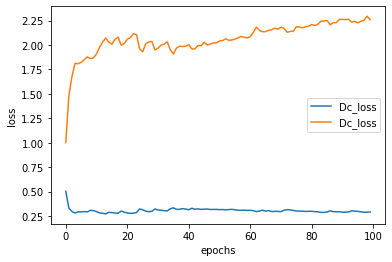

In [16]:
plt.plot([i.item() for i in Dc_loss_list], label='Dc_loss')
plt.plot([i.item() for i in Gan_loss_list], label='Dc_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## <strong> result2 - Not Using BN </strong>

BN을 사용하지 않은 경우 BN을 사용한 경우보다 노이즈가 적게 낀다. <br> 학습도 잘 되는 것을 확인할 수 있다.

loss 그래프는 다음과 같다.

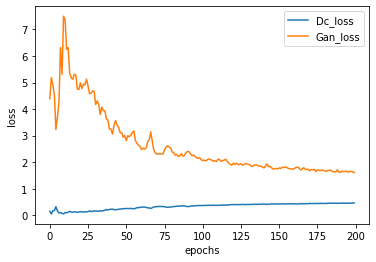

In [44]:
plt.plot([i.item() for i in Dc_loss_list], label='Dc_loss')
plt.plot([i.item() for i in Gan_loss_list], label='Gan_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()